In [1]:
from imgen3flip_kisser import Model, ImageDB, weights_path, OPTS, ImageBatch
from torch_utils import model_numel

Weight path is data/image-flip-kisser-weights-1024x2-torch.bfloat16.bin


In [3]:
import torch
from torch import Tensor
from torch import tensor
import random
import torch.nn as nn
import torch.nn.functional as F
from tqdm.auto import tqdm
from pathlib import Path
from einops import rearrange, repeat
from typing import Optional
import torchvision.transforms.functional as VF
import torchvision as TV

In [4]:
model = Model()
print(model_numel(model))

30015168


In [5]:
print(f"Loading {weights_path}")
model.load_state_dict(torch.load(weights_path))

Loading data/image-flip-kisser-weights-1024x2-torch.bfloat16.bin


<All keys matched successfully>

In [6]:
model.eval()
model.requires_grad_(False)

Model(
  (from_rgb): RGBToModelKISS()
  (to_rgb): ModelToRGBKISS(
    (norm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
  )
  (layers): ModuleList(
    (0-1): 2 x MambaFlipVlop(
      (mb_forward): MambaWrap(
        (mamba): Mamba2Simple(
          (in_proj): Linear(in_features=1024, out_features=4240, bias=False)
          (conv1d): Conv1d(2176, 2176, kernel_size=(4,), stride=(1,), padding=(3,), groups=2176)
          (act): SiLU()
          (norm): RMSNorm()
          (out_proj): Linear(in_features=2048, out_features=1024, bias=False)
        )
        (norm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
      )
      (mb_backward): MambaWrap(
        (mamba): Mamba2Simple(
          (in_proj): Linear(in_features=1024, out_features=4240, bias=False)
          (conv1d): Conv1d(2176, 2176, kernel_size=(4,), stride=(1,), padding=(3,), groups=2176)
          (act): SiLU()
          (norm): RMSNorm()
          (out_proj): Linear(in_features=2048, out_features=1024,

In [7]:
image_db = ImageDB(dtype=OPTS["dtype"])

Load tensors file


In [8]:
def to_pil(im):
    rgb = rearrange(im, "B H W C -> C H (B W)")
    rgb = VF.to_pil_image(rgb.float())
    return rgb

def run_from_batch(batch, show64=True):
    orig_small = repeat(batch.im8, "B H W C -> B (H 8) (W 8) C")    
    orig_2d = batch.im64
    batch.im64 = torch.zeros_like(batch.im64)
    generated = model(batch).im64
    if show64:
        new_img = torch.cat((orig_small, orig_2d, generated), dim=1)
    else:
        new_img = torch.cat((orig_small, generated), dim=1)
    return to_pil(new_img)

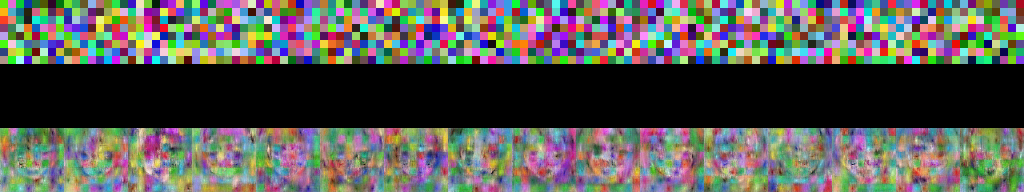

In [9]:
def rand_batch(n):
    im8 = torch.rand(n, 8, 8, 3, **OPTS)    
    batch = im8_to_batch(im8)
    return run_from_batch(batch)
def im8_to_batch(im8):
    im64 = torch.zeros(len(im8), 64, 64, 3, **OPTS)
    batch = ImageBatch(im8.to(**OPTS), im64, 0)
    return batch
def gen_circle(px=3.5, py=3.5, noise=0.0):
    # generate circle-like pattern
    n = 8
    x = torch.arange(n, dtype=OPTS["dtype"]).view(1, n).repeat(n, 1)
    x = torch.stack((x, x.mT), -1)
    x = (x - torch.tensor([px, py]))**2
    x = x.sum(-1).sqrt()
    x = x - x.min()
    x = 1.0 - (x / x.max())
    x = repeat(x, "H W -> B H W C", B=1, C=3)
    a = torch.rand_like(x)**2 * noise
    x = x + a
    return x.to(**OPTS)
rand_batch(16)    

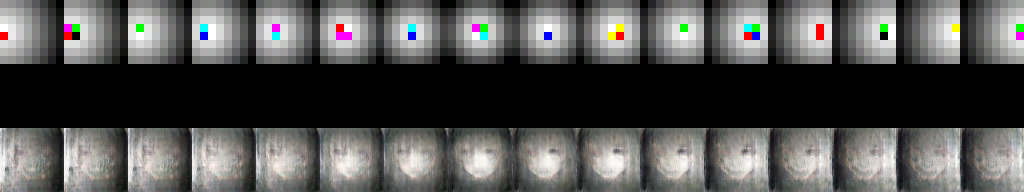

In [10]:
batch = im8_to_batch(torch.cat([gen_circle(px=x*0.5, noise=0.01) for x in range(16)]))
run_from_batch(batch)

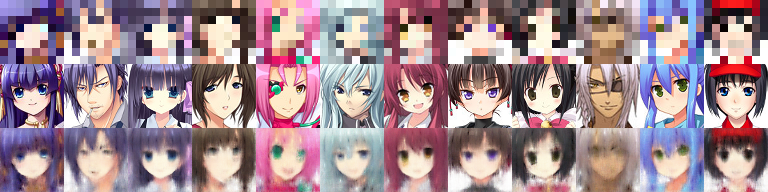

In [12]:
run_from_batch(image_db.random_batch(12, split="valid"))

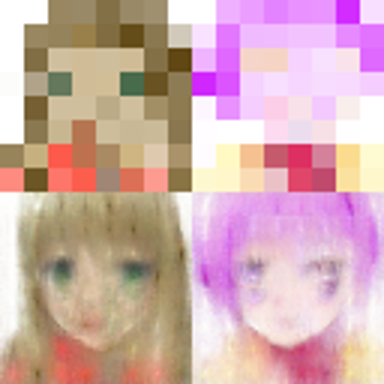

In [13]:
faces = list(Path("./krita/").glob("face*.png"))
faces.sort()
faces_im = [rearrange(TV.io.read_image(face_path)[:3], "C H W -> 1 H W C") / 255.0 for face_path in faces]
faces_im = torch.cat(faces_im)
batch = im8_to_batch(faces_im)
f=3
real_img = run_from_batch(batch, show64=False)
real_img.resize((real_img.width*f, real_img.height * f))

In [14]:
model_numel(model)

30015168